In [ ]:
import sys
import logging
import os
import math
import json
from tqdm import tqdm
import warnings
from IPython.display import display, Audio

import numpy as np
import librosa

import torch

import scdata

sys.path.append('..')
logging.getLogger().setLevel(logging.INFO)
warnings.filterwarnings('ignore')

from aural_travels.data import soundcloud
from aural_travels.train import visualizer

MODEL_DIR = '/home/leo/src/aural-travels/models/nat_vqgan_layers16'
DATA_DIR = '/home/leo/src/scdata'

In [ ]:
with open(os.path.join(MODEL_DIR, 'params.json')) as f:
    params = json.load(f)
    
params

In [ ]:
#split = 'training'
split = 'validation'

dataset = visualizer.load_dataset(params,
                                  split,
                                  torch.load(f'../models/encoding/{params["image_repr"]}/{split}.pt'))
image_repr = visualizer.create_image_repr(params)
model = visualizer.create_model(params, image_repr, dataset)
model.eval().to('cuda')

checkpoint = torch.load(os.path.join(MODEL_DIR, 'last_checkpoint.pt'))
model.load_state_dict(checkpoint['model'])

checkpoint['global_step']

In [ ]:
def show(image_seq, save=None):
    image = image_repr.tensor_to_image(image_repr.decode(image_seq)[0])
    display(image)
    if save:
        image.save(save)
    return image

corrupt_image_seq = image_repr.rand_image_seq(1, device='cuda')
show(corrupt_image_seq)

corrupt_image_seq = image_repr.rand_image_seq(1, device='cuda', patch_size=4)
show(corrupt_image_seq)

corrupt_image_seq = image_repr.zeros_image_seq(1, device='cuda')
show(corrupt_image_seq)

print('')

In [ ]:
top_k = 0
temperature = 1

indices = list(range(3))

for idx in indices:
    track = dataset.tracks[idx]
    print(f'{track["genre"]}: {track["title"]} ({track["id"]})')
    
    audio, ref_image_seq = dataset[idx]
    
    audio = audio[None, ...].to('cuda')
    ref_image_seq = ref_image_seq[None, ...].to('cuda')

    print('ref')
    show(ref_image_seq)
    
#     print('from_zeros')
#     image_seq = model.generate_image_seq(audio,
#                                          top_k=top_k,
#                                          temperature=temperature,
#                                          corrupt_image_seq=image_repr.zeros_image_seq(1, device='cuda'))
#    show(image_seq)
    
    for i in range(1):
        print('from_rand')
        image_seq = model.generate_image_seq(audio,
                                             top_k=top_k,
                                             temperature=temperature,
                                             corrupt_image_seq=image_repr.rand_image_seq(1, patch_size=4, device='cuda'))
        print((image_seq == ref_image_seq).sum())
        show(image_seq)
        
    print('from_corrupt')
    corrupt_image_seq = visualizer.corrupt_image_seq('uniform',
                                                     image_repr.vocab_size(),
                                                     ref_image_seq[0].clone())[None, ...]
    image_seq = model.generate_image_seq(audio,
                                         top_k=top_k,
                                         temperature=temperature,
                                         corrupt_image_seq=corrupt_image_seq)
    print((corrupt_image_seq == ref_image_seq).sum())
    print((image_seq == ref_image_seq).sum())
    show(image_seq)
    
    print('corrupt')
    show(corrupt_image_seq)

In [ ]:
from IPython.display import Audio

track_idx = 4
path = scdata.get_audio_path(os.path.join(DATA_DIR, 'audio'), dataset.tracks[track_idx]['id'])
print(path)
Audio(path)

In [ ]:
mel = torch.tensor(dataset.load_features(track_idx), dtype=torch.float)
mel = (mel - dataset.mfcc_mean) * dataset.mfcc_std_inv
print(mel.shape)
print(mel.shape[0] / 21)

In [ ]:
import msaf

boundaries, labels = msaf.process(path)

In [ ]:
boundaries

In [ ]:
labels

In [19]:
dataset.tracks[4]

{'artwork_url': 'https://i1.sndcdn.com/artworks-000234789846-yxvpty-large.jpg',
 'caption': None,
 'commentable': True,
 'comment_count': 24,
 'created_at': '2017-07-23T10:59:52Z',
 'description': 'What is your driving force?\n\nPhoto by Nik MacMillan on Unsplash',
 'downloadable': True,
 'download_count': 35,
 'duration': 136240,
 'full_duration': 136240,
 'embeddable_by': 'all',
 'genre': 'Jazz & Blues',
 'has_downloads_left': True,
 'id': 334422210,
 'kind': 'track',
 'label_name': None,
 'last_modified': '2021-03-27T19:52:51Z',
 'license': 'cc-by',
 'likes_count': 67,
 'permalink': 'driving-force',
 'permalink_url': 'https://soundcloud.com/the-fisherman/driving-force',
 'playback_count': 1148,
 'public': True,
 'publisher_metadata': {'id': 334422210,
  'urn': 'soundcloud:tracks:334422210',
  'artist': 'The Fisherman',
  'contains_music': True,
  'isrc': 'USDY41856174',
  'explicit': False,
  'writer_composer': 'Antonios Panou'},
 'purchase_title': None,
 'purchase_url': None,
 'rel

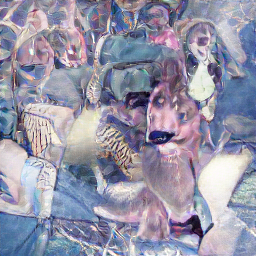

env_noise 121.69999999999736 2.3995342 14
env_noise 121.79999999999735 2.0328374 12
env_noise 121.89999999999735 3.30249 22
cross_noise 121.89999999999735
env_noise 121.99999999999734 1.6900163 9
env_noise 122.09999999999734 3.456107 23
env_noise 122.19999999999733 2.0644886 12
env_noise 122.29999999999733 5.4482446 41
cross_noise 122.29999999999733
env_noise 122.39999999999732 2.318894 14
env_noise 122.49999999999731 4.9127855 36
env_noise 122.59999999999731 4.9127855 36
env_noise 122.6999999999973 1.4832784 8
env_noise 122.7999999999973 1.299942 6
cross_noise 122.7999999999973
env_noise 122.89999999999729 1.0291595 5


In [ ]:
from IPython.display import clear_output

from librosa.onset import onset_strength
from librosa.beat import beat_track

from aural_travels import generate

frames_dir = os.path.join(MODEL_DIR, 'gen', 'frames') 
os.makedirs(frames_dir, exist_ok=True)

track_idx = 4
last_image_seq = image_repr.rand_image_seq(1, device='cuda', patch_size=4)

mel = torch.tensor(dataset.load_features(track_idx), dtype=torch.float)
mel = (mel - dataset.mfcc_mean) * dataset.mfcc_std_inv

path = scdata.get_audio_path(os.path.join(DATA_DIR, 'audio'), dataset.tracks[track_idx]['id'])
y, _ = librosa.load(path, sr=dataset.sample_rate, mono=True)
onset_env = onset_strength(y, sr=dataset.sample_rate)

bpm, beats = beat_track(y, sr=dataset.sample_rate, units='time')

def noise(time, next_time, image_seq):
    generate.onset_env_noise(image_repr=model.image_repr,
                             onset_env=onset_env,
                             time=time,
                             next_time=next_time,
                             image_seq=image_seq,
                             power=1.25,
                             scale=5)
    generate.beat_cross_noise(image_repr=model.image_repr,
                              beats=beats,
                              time=time,
                              next_time=next_time,
                              image_seq=image_seq)
    generate.segment_reset_noise(image_repr=model.image_repr,
                                 boundaries=boundaries,
                                 time=time,
                                 next_time=next_time,
                                 image_seq=image_seq)

keyframes = generate.keyframes(model=model,
                               mel=mel,
                               last_image_seq=last_image_seq,
                               fps=10.0,
                               noise=noise,
                               temperature=1.5,
                               device='cuda')

frames = generate.interpolate(image_repr=image_repr,
                              keyframes=keyframes,
                              interframes=6)

for i, frame in enumerate(frames):
    image = image_repr.tensor_to_image(frame)
    if i % 100 == 0:
        clear_output(wait=True)
        display(image)
    image.save(os.path.join(frames_dir, f'{i}.png'))

In [ ]:
def show_gif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

show_gif(os.path.join(frames_dir, 'out.gif'))

In [ ]:
from IPython.display import Video
Video(os.path.join(frames_dir, 'out.mp4'), embed=True)